In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import nrrd
import json
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
import requests
from anatomy.anatomy_api import AnatomyApi
import scipy.stats as stats
import statsmodels.api as sm
from scipy.optimize import curve_fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.graphics import utils
from statsmodels.formula.api import ols
import scipy

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

distance_threshold = 800
overlap_threshold = 0.05

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
aapi = AnatomyApi()
ss = aapi.get_summary_structure_data('id')
mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
isocortex = structure_tree.get_structures_by_acronym(['Isocortex'])[0]
cla = structure_tree.get_structures_by_acronym(['CLA'])[0]['id']
HPF = structure_tree.get_structures_by_acronym(['HPF'])[0]
iso = structure_tree.descendant_ids([isocortex['id']])[0]
iso = [structure for structure in iso if structure in ss]
hipp = structure_tree.descendant_ids([HPF['id']])[0]
hipp = [structure for structure in hipp if structure in ss]
ia_map = structure_tree.get_id_acronym_map()
ai_map = {value:key for key, value in ia_map.items()}
ctx_strs = [ai_map[structure] for structure in iso]
hipp_strs = [ai_map[structure] for structure in hipp]
valid_strs = ctx_strs#+hipp_strs #No Cla

In [3]:
import platform
if platform.system() == 'Darwin':
    path = '/Users/jenniferwh/Dropbox/DMN data/correlations/_final'
    full_td_dataset = pd.read_csv(r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/target_defined_dataset.csv')
    savepath = r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/Figure_5/model_fit'
elif platform.system() == 'Windows':
    path = r'C:\Users\jenniferwh\Dropbox\DMN data\correlations\_final'
    full_td_dataset = pd.read_csv(r"C:\Users\jenniferwh\Dropbox (Allen Institute)\Mesoscale Connectome Papers in Progress\2019 DMN\target_defined_dataset.csv")
td_dataset = full_td_dataset[full_td_dataset['include'] == 'yes']
td_dataset = td_dataset[td_dataset['source'].isin(valid_strs)]
td_dataset = td_dataset[td_dataset['target_by_polygon'] != 'POST']
print(len(td_dataset))

121


In [4]:
# including primary/secondary switch matches within 500 um, all others no distance or overlap constraint
dat = pd.read_csv(os.path.join(path, 'td_matched_correlations.csv'))
print(len(dat))
dat = dat[dat['image_series_id'].isin(td_dataset['image_series_id'].unique())]
dat = dat[dat['match_id'].isin(td_dataset['image_series_id'].unique())]
dat = dat[dat['same_primary'] == True]
dat = dat[dat['same secondary for <60% primary'] != False]
print(len(dat))


1397
973


In [5]:
dat = dat.merge(td_dataset[['image_series_id', 'target_by_polygon', 'CAV_percent_DMN']],
               on = 'image_series_id', how = 'left')
dat.rename(columns = {'CAV_percent_DMN': 'td_CAV_percent_DMN',
                     'target_by_polygon': 'td_target'}, inplace = True)
td_dataset['match_id'] = td_dataset['image_series_id']
dat = dat.merge(td_dataset[['match_id', 'target_by_polygon', 'CAV_percent_DMN']],
               on = 'match_id', how = 'left')
dat.rename(columns = {'CAV_percent_DMN': 'match_CAV_percent_DMN',
                     'target_by_polygon': 'match_target'}, inplace = True)

In [6]:
# check for duplicates
dat['index_original'] = dat.groupby(['image_series_id', 'match_id']).image_series_id.transform('idxmin')    
dat = dat[~dat.duplicated(subset=['image_series_id', 'match_id'], keep='first')]
for isid in dat['image_series_id'].unique():
    matches = dat[dat['image_series_id'] == isid]['match_id'].values
    for match in matches:
        index = dat[(dat['image_series_id'] == match) &
                        (dat['match_id'] == isid)].index
        dat = dat.drop(index)
print(len(dat))

495


In [7]:
# Clearly distance is the most important factor. Apply distance threshold
dat = dat[dat['distance'] < distance_threshold]
print(len(dat))
dat = dat[dat['dice_coefficient'] > overlap_threshold]
print(len(dat))

357
241


In [8]:
print(len(dat))
print(len(dat['match_id'].unique()))

241
76


In [9]:
plot_order = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl','ORBvl', 
              'VISam', 'RSPd', 'RSPv', 'RSPagl', 
              'MOs', 'ECT', 'VISl', 'VISp', 'VISpm']

In [10]:
print([source for source in dat['source'].unique() if source not in plot_order])
print([source for source in plot_order if source not in dat['source'].unique()])

[]
[]


In [11]:
dat.groupby('source').count().reset_index()[['source', 'match_id']]

,source,match_id
0,ACAd,17
1,ACAv,6
2,ECT,1
3,ILA,1
4,MOs,2
5,ORBl,6
6,ORBvl,22
7,PL,3
8,RSPagl,2
9,RSPd,1


## Proceed with the best model

#### model fit parameters = [-1.49862876e-01, 8.48657022e-02, -3.46958054e-05,  4.37213721e-02, 8.75721400e-01]
 

In [12]:
def exp(X, a, b, c, d, e):
    x,y,z = X
    return a * 10**(-x / b) + (c * y) + (d * z) + e
popt = [-1.49862876e-01, 8.48657022e-02, -3.46958054e-05, 4.37213721e-02, 8.75721400e-01]

In [13]:
dat['exp_predicted'] = exp((dat['td_injection_size'],
                               dat['distance'].values,
                              dat['dice_coefficient'].values), *popt)

In [14]:
def predband(x, xd, yd, f_vars, conf=0.95):
    """
    Code adapted from Rodrigo Nemmen's post:
    http://astropython.blogspot.com.ar/2011/12/calculating-prediction-band-
    of-linear.html

    Calculates the prediction band of the regression model at the
    desired confidence level.

    Clarification of the difference between confidence and prediction bands:

    "The prediction bands are further from the best-fit line than the
    confidence bands, a lot further if you have many data points. The 95%
    prediction band is the area in which you expect 95% of all data points
    to fall. In contrast, the 95% confidence band is the area that has a
    95% chance of containing the true regression line."
    (from http://www.graphpad.com/guides/prism/6/curve-fitting/index.htm?
    reg_graphing_tips_linear_regressio.htm)

    Arguments:
    - x: array with x values to calculate the confidence band.
    - xd, yd: data arrays.
    - a, b, c: linear fit parameters.
    - conf: desired confidence level, by default 0.95 (2 sigma)

    References:
    1. http://www.JerryDallal.com/LHSP/slr.htm, Introduction to Simple Linear
    Regression, Gerard E. Dallal, Ph.D.
    """
    for ix, val in enumerate(xd):
        if all(x == val):
            index = ix
    alpha = 1. - conf    # Significance
    N = len(xd) * len(xd[index])          # data sample size
    var_n = len(f_vars)  # Number of variables used by the fitted function.

    # Quantile of Student's t distribution for p=(1 - alpha/2)
    q = stats.t.ppf(1. - alpha / 2., N - var_n)

    # Std. deviation of an individual measurement (Bevington, eq. 6.15)
    se = np.sqrt(1. / (N - var_n) * np.sum((yd - exp(xd, *f_vars)) ** 2))

    # Auxiliary definitions
    sx = (x - xd[0].mean()) ** 2
    sxd = np.sum((xd[0] - xd[index].mean()) ** 2)

    # Predicted values (best-fit model)
    yp = exp(xd, *f_vars)
    # Prediction band
    dy = q * se * np.sqrt(1. + (1. / N) + (sx / sxd))

    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy

    return lpb, upb

In [15]:
low_pred_band = pd.DataFrame()
high_pred_band = pd.DataFrame()
for key in ['td_injection_size', 'distance', 'dice_coefficient']:
    low_pred_band[key] = predband(dat[key].values, 
                                       (dat['td_injection_size'].values, 
                                        dat['distance'].values,
                                        dat['dice_coefficient'].values), 
                                       dat['spearman_correlation'].values, popt)[0]
    high_pred_band[key] = predband(dat[key].values, 
                                       (dat['td_injection_size'].values, 
                                        dat['distance'].values,
                                        dat['dice_coefficient'].values), 
                                       dat['spearman_correlation'].values, popt)[1]

In [16]:
dat['low_pred_band'] = low_pred_band.min(axis = 1).values
dat['high_pred_band'] = high_pred_band.max(axis = 1).values

In [17]:
print(len(dat[dat['spearman_correlation'] < dat['exp_predicted']]))
print(len(dat[dat['spearman_correlation'] < dat['low_pred_band']]['image_series_id'].unique()))
print(len(dat))
dat[dat['spearman_correlation'] < dat['low_pred_band']]['source'].unique()

118
14
241


array(['VISp', 'ORBvl', 'ORBl', 'RSPv'], dtype=object)

In [18]:
float(len(dat[dat['spearman_correlation'] < dat['low_pred_band']][[
    'source', 'image_series_id', 'spearman_correlation']]))/len(dat)

0.11618257261410789

## Find mean per experiment for target-defined data

In [19]:
all_isids = np.unique(np.concatenate(
    (dat['image_series_id'].unique(), dat['match_id'].unique())))
num_comparisons = []
corr = []
predicted_corr = []
sources = []
inj_sizes = []
mean_ol = []
mean_dist = []
mean_low_pred = []
mean_high_pred = []
frac_low_corr = []
for isid in all_isids:
    if len(dat[dat['image_series_id'] == isid]['td_primary_source'].values) > 0:
        sources.append(dat[dat['image_series_id'] == isid][
            'td_primary_source'].values[0])
        inj_sizes.append(dat[dat['image_series_id'] == isid][
            'td_injection_size'].values[0])
    else:
        sources.append(dat[dat['match_id'] == isid][
            'match_primary_source'].values[0])
        inj_sizes.append(dat[dat['match_id'] == isid][
            'match_injection_size'].values[0])
    dataset = dat[(dat['image_series_id'] == isid) | (
        dat['match_id'] == isid)]
    
    num_comparisons.append(len(dataset))
    frac_low_corr.append(
        len(dataset[dataset['spearman_correlation'] < dataset['low_pred_band']])/len(dataset))
    corr.append(dataset['spearman_correlation'].mean())
    predicted_corr.append(dataset['exp_predicted'].mean())
    mean_ol.append(dataset['dice_coefficient'].mean())
    mean_dist.append(dataset['distance'].mean())
    mean_low_pred.append(dataset['low_pred_band'].min())
    mean_high_pred.append(dataset['high_pred_band'].max())

In [20]:
meandat = pd.DataFrame({'image_series_id': all_isids, 'source': sources, 
                       'injection_size': inj_sizes, 'number_comparisons': num_comparisons, 
                       'fraction_low_corr': frac_low_corr,
                       'spearman_correlation': corr, 'exp_predicted': predicted_corr,
                      'mean_overlap': mean_ol, 'mean_distance': mean_dist, 
                       'low_pred': mean_low_pred})
print(len(meandat))

98


In [21]:
meansig = meandat[meandat['fraction_low_corr'] > 0.5]

In [22]:
len(meansig)

8

In [23]:
meansig['source'].unique()

array(['VISp', 'ORBvl', 'ORBl', 'RSPv'], dtype=object)

In [24]:
meandat.loc[meandat['image_series_id'].isin(meansig['image_series_id'].values), 
            'low_corr_experiment'] = True

## Boxplots by source

In [25]:
plot_order = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBvl', 
              'VISam', 'RSPd', 'RSPv', 'RSPagl', 
              'MOs', 'ECT', 'VISl', 'VISp', 'VISpm']

In [26]:
print([source for source in dat['source'].unique() if source not in plot_order])
print([source for source in plot_order if source not in dat['source'].unique()])

[]
[]


In [27]:
dat.loc[(dat['td_CAV_percent_DMN'] > 50) &
        (dat['match_CAV_percent_DMN'] > 50), 'experiment_type'] = 'both in'
dat.loc[(dat['td_CAV_percent_DMN'] < 50) &
        (dat['match_CAV_percent_DMN'] < 50), 'experiment_type'] = 'both out'
dat.loc[(dat['td_CAV_percent_DMN'] < 50) &
        (dat['match_CAV_percent_DMN'] > 50), 'experiment_type'] = 'in-out'
dat.loc[(dat['td_CAV_percent_DMN'] > 50) &
        (dat['match_CAV_percent_DMN'] < 50), 'experiment_type'] = 'in-out'

In [28]:
dat['experiment_type'].unique()

array(['both out', 'in-out', 'both in', nan], dtype=object)

In [29]:
pltdat = dat[['source', 'exp_predicted', 
                             'spearman_correlation', 'experiment_type']]
pltdat_sig = meandat[meandat['fraction_low_corr'] > 0.5][
    ['source', 'exp_predicted', 'spearman_correlation']]

"\nplt.savefig(os.path.join(savepath, \n                         'WT_TD_observed_corr_all_sources.pdf'), \n            bbox_inches='tight',  pad_inches=0.3, format='pdf', transparent = True, dpi=300)\n            "

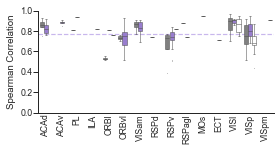

In [30]:
fig, ax = plt.subplots(figsize = (4, 2.2))
sns.boxplot('source', 'spearman_correlation', data = dat, order = plot_order, 
            hue = 'experiment_type',
            palette = ['gray', 'mediumpurple', 'w'], 
            hue_order = ['in-out', 'both in', 'both out'],
            fliersize = 0.1, linewidth = 0.5)
ax.axhline(y=dat['spearman_correlation'].mean(), 
           c='mediumpurple', alpha = 0.5, 
           linestyle = '--', zorder = -1)
plt.xticks(rotation = 90);
ax.tick_params(top=False, right=False, left=True, pad=1)
ax.tick_params('x', pad = -3)
sns.despine()
ax.set_ylim([0, 1]);
ax.set_ylabel('Spearman Correlation')
ax.set_xlabel(None)
ax.legend_.remove()
plt.tight_layout()
'''
plt.savefig(os.path.join(savepath, 
                         'WT_TD_observed_corr_all_sources.pdf'), 
            bbox_inches='tight',  pad_inches=0.3, format='pdf', transparent = True, dpi=300)
            '''

In [31]:
plot_order = [region for region in plot_order if region in dat['source'].unique()]

print(plot_order)

['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBvl', 'VISam', 'RSPd', 'RSPv', 'RSPagl', 'MOs', 'ECT', 'VISl', 'VISp', 'VISpm']


In [32]:
pltdat['experiment_type'].unique()

array(['both out', 'in-out', 'both in', nan], dtype=object)

In [33]:
print(len(dat[dat['spearman_correlation'] > dat['high_pred_band']]))
print(len(dat[dat['spearman_correlation'] < dat['low_pred_band']]))

9
28


In [34]:
len(meandat[meandat['fraction_low_corr'] > 0.5])

8

In [35]:
meandat[meandat['fraction_low_corr'] > 0.5]['source'].unique()

array(['VISp', 'ORBvl', 'ORBl', 'RSPv'], dtype=object)

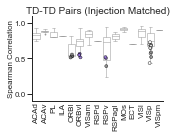

In [36]:
fig, ax = plt.subplots(figsize = (2.5, 2))
sns.boxplot('source', 'spearman_correlation', data = dat, order = plot_order, 
            color = 'w', linewidth = 0.5, fliersize = 1)
sns.stripplot('source', 'spearman_correlation', 
              data = dat[dat['spearman_correlation'] < dat['low_pred_band']], 
              order = plot_order, 
            hue = 'experiment_type',
            palette = ['gray', 'mediumpurple', 'w'], 
            hue_order = ['in-out', 'both in', 'both out'], edgecolor = 'k',
            linewidth = 0.5, s=3, alpha = 0.8)

plt.xticks(rotation = 90, fontsize = 8);
ax.tick_params(top=False, right=False, left=True, pad=1)
ax.tick_params('x', pad = -3)
sns.despine()
ax.set_ylim([-0.1,1.1])
ax.yaxis.labelpad = -1
plt.yticks([0, 0.5, 1], fontsize = 8)
ax.set_ylabel('Spearman Correlation', fontsize = 8, labelpad=1)
ax.set_xlabel(None)
plt.title('TD-TD Pairs (Injection Matched)', fontsize = 10, y=0.96)
ax.legend_.remove()
plt.tight_layout()

plt.savefig(os.path.join(savepath, 
                         'TD-TD correlation boxplots.pdf'), 
            bbox_inches='tight', format='pdf', transparent = True, dpi=300)

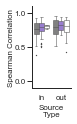

In [37]:
in_strs = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 'RSPagl',
    'RSPd', 'RSPv', 'SSp-tr', 'SSp-ll', 'MOs']
dat.loc[dat['source'].isin(in_strs), 'in-out'] = 'in'
dat.loc[~dat['source'].isin(in_strs), 'in-out'] = 'out'
type_order = ['in', 'out']
fig, ax = plt.subplots(1, figsize = (0.7, 1.5))
sns.boxplot('in-out', 'spearman_correlation',
              data = dat[dat['source'].isin(plot_order)], order = type_order,
              hue = 'experiment_type', hue_order = ['in-out', 'both in', 'both out'],
              linewidth = 0.5, palette = ['gray','mediumpurple', 'w'],
             fliersize = 0.5, dodge = True)
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([-0.1,1.1])
plt.xticks([0, 1], fontsize = 8, labels = ['in', 'out'])
plt.yticks([0, 0.5, 1], fontsize = 8)
ax.set_ylabel("Spearman Correlation", fontsize = 8)
ax.yaxis.labelpad = 1
sns.despine()
ax.set_xlabel("Source\nType", fontsize = 8)
ax.legend_.remove()
ax.tick_params(top = False, right = False, left = True, pad = 1)

plt.savefig(os.path.join(savepath, 'TD-TD_corr_boxplot_in-out.pdf'), 
            bbox_inches='tight', format='pdf', transparent=True, dpi=300)

In [38]:
def assign_module(df):
    df.loc[df['source'].isin(['ACAd', 'ACAv', 'ORBl','ORBm', 'ORBvl', 
                                                    'ILA', 'PL', 'FRP']), 'module'] = 'Prefrontal'
    df.loc[df['source'].isin(['VISam', 'RSPagl', 'RSPv', 'VISpm',
                                                    'VISa', 'RSPd']), 'module'] = 'Medial'
    df.loc[df['source'].isin(['SSp-tr', 'SSp-ll', 'SSp-bfd', 'SSp-un',
                                                    'SSp-ul', 'MOs', 'MOp', 'SSs', 'SSp-n',
                                                    'SSp-m']), 'module'] = 'Somatomotor'
    df.loc[df['source'].isin(['VISal', 'VISl', 'VISli', 'VISp', 'VISpl',
                                                    'VISpor', 'VISrl']), 'module'] = 'Visual'
    df.loc[df['source'].isin(['AUDpo', 'AUDd', 'AUDp', 'AUDv']), 
                    'module'] = 'Auditory'
    df.loc[df['source'].isin(['TEa', 'PERI', 'ECT', 'GU', 'AId', 'AIv',
                                                    'AIp', 'VISC']), 'module'] = 'Lateral'
    print(len(df[df['module'].isnull()]))
    return df

0


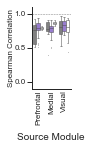

In [39]:
dat = assign_module(dat)
mod_order = ['Prefrontal', 'Medial', 'Visual']
fig, ax = plt.subplots(1, figsize = (0.7, 1.5))
sns.boxplot('module', 'spearman_correlation', data = dat, 
            order = mod_order, ax = ax, 
            hue = 'experiment_type', hue_order = ['in-out', 'both in', 'both out'],
            palette = ['gray', 'mediumpurple', 'w'],
            fliersize = 0.1, linewidth = 0.5)
ax.tick_params(top = False, right = False)
ax.set_ylim([-0.1, 1.1])
plt.yticks([0, 0.5, 1], fontsize = 8)
plt.xticks(rotation = 90, fontsize = 8)
ax.set_xlabel("Source Module", fontsize = 10)
ax.set_ylabel("Spearman Correlation", fontsize = 8)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 8
ax.tick_params(top = False, right = False, left = True, bottom = False, pad = 1)
ax.tick_params(axis = 'x', pad=-3)
ax.legend_.remove()
sns.despine()
ax.axhline(y=1, xmin=0, xmax=1, color = 'grey', linestyle = 'dashed', 
           linewidth = 0.5, zorder = -1)
plt.savefig(os.path.join(savepath, 'TD-TD_corr_by_module_and_target_boxplot_horizontal.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [40]:
from statsmodels.stats.anova import anova_lm
dat['in_out'] = dat['in-out'].values
formula = 'spearman_correlation~C(in_out)*C(experiment_type)' 
model = ols(formula, dat).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(in_out),0.0491,1.0,3.8734,0.0503
C(experiment_type),0.0258,2.0,1.0165,0.3636
C(in_out):C(experiment_type),0.0060,2.0,0.2353,0.7906
Residual,2.7903,220.0,NaN,NaN


(0.9519688487052917, 7.700013497924374e-07)


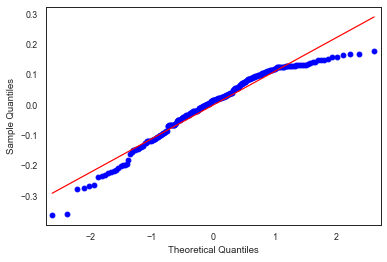

In [41]:
print(stats.shapiro(model.resid))
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [42]:
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(dat[dat['in_out'] == 'in']['spearman_correlation'], 
                    dat[dat['in_out'] == 'in']['experiment_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

TypeError: '<' not supported between instances of 'str' and 'float'

In [43]:
formula = 'spearman_correlation~C(module)*C(experiment_type)' 
model = ols(formula, dat[dat['module'].isin(['Prefrontal', 'Medial', 'Visual'])]).fit()
aov_table = anova_lm(model, typ=2)
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(module),0.0482,2.0,1.9036,0.1515
C(experiment_type),0.0239,2.0,0.9423,0.3913
C(module):C(experiment_type),0.0447,4.0,0.8821,0.4755
Residual,2.7210,215.0,NaN,NaN


(0.9543882608413696, 1.5338194998548715e-06)


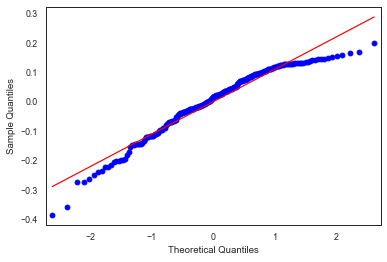

In [44]:
print(stats.shapiro(model.resid))
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [45]:
for module in dat[dat['module'].isin(['Prefrontal', 'Medial', 'Visual'])]['module'].unique():
    print(module)
    mc = MultiComparison(dat[dat['module'] == module]['spearman_correlation'], 
                     dat[dat['module'] == module]['experiment_type'])
    mc_results = mc.tukeyhsd()
    print(mc_results)

Visual
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
both in  both out -0.0293  0.5544 -0.0966 0.038  False 
both in   in-out  -0.0296  0.5154 -0.0934 0.0342 False 
both out  in-out  -0.0003   0.9   -0.0505 0.0498 False 
-------------------------------------------------------
Medial


TypeError: '<' not supported between instances of 'str' and 'float'

In [ ]:
dat[dat['module'].isnull()]['source'].unique()

In [46]:
dat['diff'] = dat['spearman_correlation'] - dat['exp_predicted']

"\nplt.savefig(os.path.join(savepath, 'TD-TD_pred_err_boxplot_in-out.pdf'), \n            bbox_inches='tight', format='pdf', transparent=True, dpi=300)\n            "

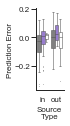

In [47]:
in_strs = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 'RSPagl',
    'RSPd', 'RSPv', 'SSp-tr', 'SSp-ll', 'MOs']
dat.loc[dat['source'].isin(in_strs), 'in-out'] = 'in'
dat.loc[~dat['source'].isin(in_strs), 'in-out'] = 'out'
type_order = ['in', 'out']
fig, ax = plt.subplots(1, figsize = (0.5, 1.5))
sns.boxplot('in-out', 'diff',
              data = dat[dat['source'].isin(plot_order)], order = type_order,
              hue = 'experiment_type', hue_order = ['in-out', 'both in', 'both out'],
              linewidth = 0.5, palette = ['gray', 'mediumpurple', 'w'],
             fliersize = 0.1, dodge = True)
ax.set_xlim([-0.5, 1.5])
#ax.set_ylim([-0.1,1.1])
plt.xticks([0, 1], fontsize = 8, labels = ['in', 'out'])
plt.yticks(fontsize = 8)
ax.set_ylabel("Prediction Error", fontsize = 8)
ax.yaxis.labelpad = 1
sns.despine()
ax.set_xlabel("Source\nType", fontsize = 8)
ax.legend_.remove()
ax.tick_params(top = False, right = False, left = True, pad = 1)
'''
plt.savefig(os.path.join(savepath, 'TD-TD_pred_err_boxplot_in-out.pdf'), 
            bbox_inches='tight', format='pdf', transparent=True, dpi=300)
            '''

"\nplt.savefig(os.path.join(savepath, 'TD-TD_prediction_err_by_module_and_target_boxplot.pdf'), \n            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)\n            "

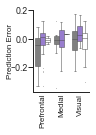

In [48]:
mod_order = ['Prefrontal', 'Medial', 'Visual']
fig, ax = plt.subplots(1, figsize = (1, 1.5))
sns.boxplot('module', 'diff', data = dat[~dat['module'].isnull()], # no ENTl or ENTm
            order = mod_order, ax = ax, 
            hue = 'experiment_type', hue_order = ['in-out', 'both in', 'both out'],
            palette = ['gray', 'mediumpurple', 'w'],
            fliersize = 0.1, linewidth = 0.5)
ax.tick_params(top = False, right = False)
#ax.set_ylim([-0.1, 1.1])
#plt.yticks([0, 0.5, 1], fontsize = 8)
plt.xticks(rotation = 90, fontsize = 8)
ax.set_xlabel(None)
ax.set_ylabel("Prediction Error", fontsize = 8)
ax.yaxis.labelpad = -3
ax.xaxis.labelpad = 5
ax.tick_params(top = False, right = False, left = True, bottom = False, pad = 1)
ax.tick_params(axis = 'x', pad=-3)
ax.legend_.remove()
sns.despine()
'''
plt.savefig(os.path.join(savepath, 'TD-TD_prediction_err_by_module_and_target_boxplot.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)
            '''

In [49]:
dat[dat['source'] == 'ACAd']['spearman_correlation'].mean()

0.8296590212352941

In [50]:
dat[(dat['image_series_id'] == 501837158) | (dat['match_id'] == 501837158)][['image_series_id',
                                                                    'match_id',
                                                                    'spearman_correlation',
                                                                    'distance',
                                                                    'dice_coefficient',
                                                                    'experiment_type']]

,image_series_id,match_id,spearman_correlation,distance,dice_coefficient,experiment_type
2,515920693,501837158,0.432731,214.496235,0.199958,both out
165,502592260,501837158,0.610649,355.903507,0.130211,in-out
250,546389260,501837158,0.697143,116.746584,0.200506,both out
267,526784559,501837158,0.590127,273.971511,0.105668,in-out
286,574637452,501837158,0.648089,80.135133,0.554591,in-out
486,501837158,485553574,0.569199,214.210440,0.122247,both out
491,501837158,501786400,0.585101,62.647480,0.336047,in-out
492,501837158,501787135,0.518765,131.484774,0.341723,in-out
496,501837158,563352720,0.592957,305.097060,0.066579,in-out
498,501837158,501711996,0.649123,173.172831,0.173748,in-out


In [51]:
dat[dat['source'] == 'VISp'].sort_values(by='spearman_correlation')[['image_series_id',
                                                                    'match_id',
                                                                    'spearman_correlation',
                                                                    'distance',
                                                                    'dice_coefficient',
                                                                    'experiment_type']]

,image_series_id,match_id,spearman_correlation,distance,dice_coefficient,experiment_type
2,515920693,501837158,0.432731,214.496235,0.199958,both out
492,501837158,501787135,0.518765,131.484774,0.341723,in-out
486,501837158,485553574,0.569199,214.210440,0.122247,both out
491,501837158,501786400,0.585101,62.647480,0.336047,in-out
267,526784559,501837158,0.590127,273.971511,0.105668,in-out
...,...,...,...,...,...,...
774,501786400,495346667,0.906037,519.819799,0.058612,in-out
783,501786400,501787135,0.913529,118.437010,0.522049,both in
658,565146821,501786400,0.915652,267.164386,0.689176,in-out
801,501711996,495346667,0.919887,350.894059,0.202741,in-out


In [52]:
vis = dat[(dat['source'] == 'VISp')]

In [53]:
len(vis[vis['spearman_correlation'] < vis['low_pred_band']])

10

In [54]:
len(vis)

80

In [55]:
len(vis[vis['spearman_correlation'] < vis['low_pred_band']])/len(vis)

0.125

In [56]:
all_isids = np.unique(np.concatenate(
    (vis['image_series_id'].unique(), vis['match_id'].unique())))

## Plot projections from various VISp injections

In [57]:
unionize_dat = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = all_isids,
                                                is_injection = False,
                                                hemisphere_ids = [1],
                                                structure_ids = ss))

In [58]:
vis_targets = ['VISli', 'VISl', 'VISal', 'VISpm', 'VISam', 'VISrl']
structures = [ia_map[structure] for structure in vis_targets]
pltdat = unionize_dat[unionize_dat['structure_id'].isin(structures)]
pltdat.loc[np.log10(pltdat['normalized_projection_volume']) < -2.5,
                          'normalized_projection_volume'] = 0.005

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


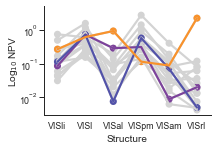

In [63]:
fig, ax = plt.subplots(figsize = (3, 2))
for isid in pltdat['experiment_id'].unique():
    sns.pointplot('structure_id', 'normalized_projection_volume', 
              data = pltdat[pltdat['experiment_id'] == isid],
             order = structures, color = 'lightgray', zorder = 1)
sns.pointplot('structure_id', 'normalized_projection_volume', 
          data = pltdat[pltdat['experiment_id'] == 501837158], #VISpAUDp
         order = structures, color='#7c429b', ax = ax, zorder = 2)
sns.pointplot('structure_id', 'normalized_projection_volume', 
          data = pltdat[pltdat['experiment_id'] == 501787135], #VISpRSPagl
         order = structures, color='#5252a9', ax = ax, zorder = 3)
sns.pointplot('structure_id', 'normalized_projection_volume', 
          data = pltdat[pltdat['experiment_id'] == 539323512], #VISpSSp-bfd
         order = structures, color='#f9922b', ax = ax, zorder = 4)
ax.set_xticklabels(vis_targets)
ax.set_ylim([0.003, 5])
ax.set_yscale('log')
sns.despine()
ax.set_ylabel('Log$_{10}$ NPV', fontsize = 10)
ax.set_xlabel('Structure', fontsize = 10)
ax.tick_params(left = True, pad = 1)
ax.yaxis.labelpad = -1
plt.savefig(os.path.join(savepath, 'VISual_targets_NPV.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [64]:
vis_examples = [485553574, 495346667, 501837158, 515920693, 546389260, 561918178, 563205064]
for isid in vis_examples:
    dataset = dat[(dat['image_series_id'] == isid) | (dat['match_id'] == isid)]
    if len(dataset[(dataset['image_series_id'].isin(vis_examples)) |
                  (dataset['match_id'].isin(vis_examples))]) < 3:
        print(isid)

563205064


In [65]:
dat = dat.merge(td_dataset[['image_series_id', 'target_by_polygon']],
                     on = 'image_series_id', how = 'left')

In [66]:
vis_examples = dat[(dat['source'] == 'VISp') & (dat['target_by_polygon'] == 'VISl')][
    'image_series_id'].unique()
pltdat = pltdat[pltdat['experiment_id'].isin(vis_examples)]

In [67]:
vis_examples

array([515920693, 561918178, 485553574])

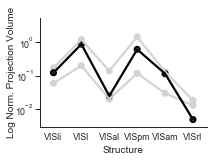

In [68]:
fig, ax = plt.subplots(figsize = (3, 2))
for isid in vis_examples:
    sns.pointplot('structure_id', 'normalized_projection_volume', 
              data = pltdat[pltdat['experiment_id'] == isid],
             order = structures, color = 'lightgray')
sns.pointplot('structure_id', 'normalized_projection_volume', 
          data = pltdat[pltdat['experiment_id'] == 515920693], 
         order = structures, color='k', ax = ax)
ax.set_xticklabels(vis_targets)
ax.set_ylim([0.003, 5])
ax.set_yscale('log')
sns.despine()
ax.set_ylabel('Log Norm. Projection Volume', fontsize = 10)
ax.set_xlabel('Structure', fontsize = 10)
ax.tick_params(left = True, pad = 1)
ax.yaxis.labelpad = -1
plt.savefig(os.path.join(savepath, 'VISp_VISl_projections.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [69]:
pltdat = unionize_dat[unionize_dat['structure_id'].isin(structures)]
pltdat.loc[np.log10(pltdat['normalized_projection_volume']) < -2.5,
                          'normalized_projection_volume'] = 0.02
rsp_examples = [501786400, 501787135, 563352720]
pltdat = pltdat[pltdat['experiment_id'].isin(rsp_examples)]

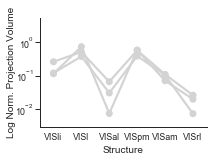

In [70]:
fig, ax = plt.subplots(figsize = (3, 2))
for isid in pltdat['experiment_id'].unique():
    sns.pointplot('structure_id', 'normalized_projection_volume', 
              data = pltdat[pltdat['experiment_id'] == isid],
             order = structures, color = 'lightgray')
sns.pointplot('structure_id', 'normalized_projection_volume', 
          data = pltdat[pltdat['experiment_id'] == 515920693], 
         order = structures, color='r', ax = ax)
ax.set_xticklabels(vis_targets)
ax.set_ylim([0.003, 5])
ax.set_yscale('log')
sns.despine()
ax.set_ylabel('Log Norm. Projection Volume', fontsize = 10)
ax.set_xlabel('Structure', fontsize = 10)
ax.tick_params(left = True, pad = 1)
ax.yaxis.labelpad = -1
plt.savefig(os.path.join(savepath, 'VISp_RSP_projections.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [71]:
dat[(dat['source'] == 'ORBvl') & (dat['target_by_polygon'] == 'VISam')]

,match_id,fraction of match covered by td exclusion zone,pearson_correlation,fraction of match covered by td injection,distance,dice_coefficient,spearman_correlation,injection_overlap,image_series_id,source,...,index_original,exp_predicted,low_pred_band,high_pred_band,experiment_type,in-out,module,in_out,diff,target_by_polygon
91,479115470,0.517488,0.892690,0.226711,268.343057,0.340603,0.720992,0.304218,617898760,ORBvl,...,237,0.755725,0.617425,0.894025,both in,in,Prefrontal,in,-0.034733,VISam
92,617900105,0.630849,0.950919,0.267995,319.582587,0.080839,0.702002,0.044220,617898760,ORBvl,...,238,0.742590,0.604155,0.881025,in-out,in,Prefrontal,in,-0.040588,VISam
93,521955016,0.795439,0.919721,0.368440,297.858213,0.324035,0.780707,0.231792,617898760,ORBvl,...,239,0.753977,0.615601,0.892352,both in,in,Prefrontal,in,0.026730,VISam
94,523177830,0.960000,0.715402,0.540364,256.341683,0.597117,0.756833,0.396149,617898760,ORBvl,...,240,0.767357,0.628726,0.905988,both in,in,Prefrontal,in,-0.010524,VISam
95,532005897,0.803022,0.920538,0.309390,275.807457,0.365151,0.550897,0.334388,617898760,ORBvl,...,242,0.756539,0.618221,0.894858,both in,in,Prefrontal,in,-0.205643,VISam
165,479115470,0.592426,0.817603,0.195777,252.071724,0.307000,0.643117,0.220682,532005897,ORBvl,...,438,0.750781,0.612519,0.889043,both in,in,Prefrontal,in,-0.107664,VISam
166,521955016,0.966748,0.905859,0.812083,53.102107,0.554175,0.665550,0.387755,532005897,ORBvl,...,440,0.768491,0.629956,0.907027,both in,in,Prefrontal,in,-0.102941,VISam
167,523177830,0.900114,0.627265,0.614690,122.265483,0.734640,0.546604,0.443769,532005897,ORBvl,...,441,0.773982,0.634994,0.912970,both in,in,Prefrontal,in,-0.227377,VISam
176,479115470,0.602877,0.879872,0.049704,288.277990,0.086998,0.748621,0.145624,521955016,ORBvl,...,477,0.730501,0.592151,0.868851,both in,in,Prefrontal,in,0.018120,VISam
177,523177830,0.975444,0.812323,0.255545,104.462649,0.378923,0.808155,0.470474,521955016,ORBvl,...,479,0.749642,0.611419,0.887865,both in,in,Prefrontal,in,0.058513,VISam


In [72]:
dat.to_csv(os.path.join(path, 'good_td_td_correlations.csv'), index = False)

In [73]:
len(dat)

241

In [74]:
all_isids = np.unique(np.concatenate(
    (dat['image_series_id'].unique(), dat['match_id'].unique())))

In [75]:
td_matches = []
for isid in full_td_dataset['image_series_id'].unique():
    if isid in all_isids:
        dataset = np.unique(np.concatenate(
            (dat[dat['image_series_id'] == isid]['match_id'].unique(),
             dat[dat['match_id'] == isid]['image_series_id'].unique())))
        td_matches.append(dataset)
    else:
        td_matches.append([np.nan])

In [76]:
full_td_dataset['TD_matches'] = full_td_dataset['TD_matches'].astype('object')
full_td_dataset['TD_matches'] = td_matches

In [77]:
#full_td_dataset.to_csv(r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/target_defined_dataset.csv',
#                      index = False)

## Compare NPV value with p(obs)

In [78]:
basepath = r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN'
datpath = os.path.join(basepath, 'data_files')
savepath = os.path.join(basepath, '_new_figures', 'Figure_5')

In [79]:
alldat = pd.read_csv(os.path.join(datpath, 'good_td_wt_correlations.csv'))
print(len(alldat))

586


In [80]:
alldat = alldat.merge(td_dataset[['image_series_id', 'target_by_polygon']])

In [81]:
len(alldat[(alldat['source'] == 'RSPv') &
      (alldat['target_by_polygon'] == 'PL')])

2

In [82]:
alldat[(alldat['source'] == 'RSPv') &
      (alldat['target_by_polygon'] == 'PL')]['spearman_correlation']

460    0.527093
494    0.700694
Name: spearman_correlation, dtype: float64

In [83]:
isids = alldat['image_series_id'].unique()
valid_str_ids = [ia_map[structure] for structure in valid_strs]
new_expts = [868641659, 900250452]
#isids = alldat[alldat['source'] == 'RSPv']['image_series_id'].unique()
isids = [isid for isid in isids if isid not in new_expts]
match_isids = alldat['match_id'].unique()
unionize_dat = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = isids,
                                                is_injection = False,
                                                hemisphere_ids = [1,2],
                                                structure_ids = valid_str_ids))
wt_unionize = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = match_isids,
                                                is_injection = False,
                                                hemisphere_ids = [1,2],
                                                structure_ids = valid_str_ids))

In [84]:
for isid in match_isids:
    inj_hem = aapi.get_hemisphere(isid)
    if inj_hem == 2:
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 2), 'hemisphere_id'] = 0
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 1), 'hemisphere_id'] = 2
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 0), 'hemisphere_id'] = 1

In [85]:
mean_npv = wt_unionize.groupby(['structure_id',
                                'hemisphere_id'])['normalized_projection_volume'].mean()

In [86]:
unionize_dat['thresholded_npv'] = unionize_dat['normalized_projection_volume']
unionize_dat.loc[np.log10(unionize_dat['normalized_projection_volume']+0.0001) < -1.5, 
                 'thresholded_npv'] = 0

In [87]:
detected = unionize_dat[unionize_dat['thresholded_npv'] != 0].groupby(
    ['structure_id', 'hemisphere_id']).count().reset_index()[[
    'structure_id', 'hemisphere_id', 'thresholded_npv']]
detected = unionize_dat.groupby(['structure_id', 'hemisphere_id']).count().reset_index()[[
    'structure_id', 'hemisphere_id', 'normalized_projection_volume']].merge(
    detected, on = ['structure_id', 'hemisphere_id'], how = 'left')
detected.loc[detected['thresholded_npv'].isnull(), 'thresholded_npv'] = 0 # this will be count
detected['pobs'] = detected['thresholded_npv']/detected['normalized_projection_volume']
detected = detected[['structure_id', 'hemisphere_id', 'pobs']]

In [88]:
mean_npv = pd.DataFrame(mean_npv).reset_index()

In [89]:
detected = detected.merge(mean_npv, on=['structure_id', 'hemisphere_id'])
detected['log_npv'] = np.log10(detected['normalized_projection_volume']+0.0001)

In [90]:
len(detected)

86

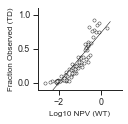

In [91]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.regplot('log_npv', 'pobs', data = detected, ci = False, color = 'w',
           scatter_kws={'s': 10,
                        'edgecolor': 'k',
                        'linewidth':0.5},
           line_kws={'color': 'k',
                    'linewidth': 0.5})
sns.despine()
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-3, 1])
ax.tick_params(bottom=True, left=True)
ax.set_xlabel('Log10 NPV (WT)', fontsize = 8)
ax.set_ylabel('Fraction Observed (TD)', fontsize = 8)
plt.savefig(os.path.join(savepath, 'NPV_mean_fraction_observed.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [92]:
detected[detected['log_npv'] < -2]['pobs'].mean()

0.01834862385321101

In [93]:
x = detected['log_npv']
y = detected['pobs']
corr = scipy.stats.pearsonr(x, y)
print(corr)

(0.9145347625043367, 9.081154472299087e-35)


In [94]:
isids = alldat[alldat['source'] == 'RSPv']['image_series_id'].unique()
new_expts = [868641659, 900250452]
isids = [isid for isid in isids if isid not in new_expts]
match_isids = alldat[alldat['source'] == 'RSPv']['match_id'].unique()
unionize_dat = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = isids,
                                                is_injection = False,
                                                hemisphere_ids = [1,2],
                                                structure_ids = valid_str_ids))
wt_unionize = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = match_isids,
                                                is_injection = False,
                                                hemisphere_ids = [1,2],
                                                structure_ids = valid_str_ids))
for isid in match_isids:
    inj_hem = aapi.get_hemisphere(isid)
    if inj_hem == 2:
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 2), 'hemisphere_id'] = 0
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 1), 'hemisphere_id'] = 2
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 0), 'hemisphere_id'] = 1
mean_npv = wt_unionize.groupby(['structure_id',
                                'hemisphere_id'])['normalized_projection_volume'].mean()
unionize_dat['thresholded_npv'] = unionize_dat['normalized_projection_volume']
unionize_dat.loc[np.log10(unionize_dat['normalized_projection_volume']+0.0001) < -1.5, 
                 'thresholded_npv'] = 0

In [95]:
rspv = unionize_dat[unionize_dat['thresholded_npv'] != 0].groupby(
    ['structure_id', 'hemisphere_id']).count().reset_index()[[
    'structure_id', 'hemisphere_id', 'thresholded_npv']]
rspv = unionize_dat.groupby(['structure_id', 'hemisphere_id']).count().reset_index()[[
    'structure_id', 'hemisphere_id', 'normalized_projection_volume']].merge(
    rspv, on = ['structure_id', 'hemisphere_id'], how = 'left')
rspv.loc[rspv['thresholded_npv'].isnull(), 'thresholded_npv'] = 0 # this will be count
rspv['pobs'] = rspv['thresholded_npv']/rspv['normalized_projection_volume']
rspv = rspv[['structure_id', 'hemisphere_id', 'pobs']]
rspv = rspv.merge(mean_npv, on=['structure_id', 'hemisphere_id'])
rspv['log_npv'] = np.log10(rspv['normalized_projection_volume']+0.0001)

In [96]:
isids = alldat[alldat['source'] == 'ACAd']['image_series_id'].unique()
new_expts = [868641659, 900250452]
isids = [isid for isid in isids if isid not in new_expts]
match_isids = alldat[alldat['source'] == 'ACAd']['match_id'].unique()
unionize_dat = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = isids,
                                                is_injection = False,
                                                hemisphere_ids = [1,2],
                                                structure_ids = valid_str_ids))
wt_unionize = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = match_isids,
                                                is_injection = False,
                                                hemisphere_ids = [1,2],
                                                structure_ids = valid_str_ids))
for isid in match_isids:
    inj_hem = aapi.get_hemisphere(isid)
    if inj_hem == 2:
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 2), 'hemisphere_id'] = 0
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 1), 'hemisphere_id'] = 2
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 0), 'hemisphere_id'] = 1
mean_npv = wt_unionize.groupby(['structure_id',
                                'hemisphere_id'])['normalized_projection_volume'].mean()
unionize_dat['thresholded_npv'] = unionize_dat['normalized_projection_volume']
unionize_dat.loc[np.log10(unionize_dat['normalized_projection_volume']+0.0001) < -1.5, 
                 'thresholded_npv'] = 0

In [97]:
acad = unionize_dat[unionize_dat['thresholded_npv'] != 0].groupby(
    ['structure_id', 'hemisphere_id']).count().reset_index()[[
    'structure_id', 'hemisphere_id', 'thresholded_npv']]
acad = unionize_dat.groupby(['structure_id', 'hemisphere_id']).count().reset_index()[[
    'structure_id', 'hemisphere_id', 'normalized_projection_volume']].merge(
    acad, on = ['structure_id', 'hemisphere_id'], how = 'left')
acad.loc[acad['thresholded_npv'].isnull(), 'thresholded_npv'] = 0 # this will be count
acad['pobs'] = acad['thresholded_npv']/acad['normalized_projection_volume']
acad = acad[['structure_id', 'hemisphere_id', 'pobs']]
acad = acad.merge(mean_npv, on=['structure_id', 'hemisphere_id'])
acad['log_npv'] = np.log10(acad['normalized_projection_volume']+0.0001)

In [98]:
isids = alldat[alldat['source'] == 'VISp']['image_series_id'].unique()
new_expts = [868641659, 900250452]
isids = [isid for isid in isids if isid not in new_expts]
match_isids = alldat[alldat['source'] == 'VISp']['match_id'].unique()
unionize_dat = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = isids,
                                                is_injection = False,
                                                hemisphere_ids = [1,2],
                                                structure_ids = valid_str_ids))
wt_unionize = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = match_isids,
                                                is_injection = False,
                                                hemisphere_ids = [1,2],
                                                structure_ids = valid_str_ids))
for isid in match_isids:
    inj_hem = aapi.get_hemisphere(isid)
    if inj_hem == 2:
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 2), 'hemisphere_id'] = 0
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 1), 'hemisphere_id'] = 2
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 0), 'hemisphere_id'] = 1
mean_npv = wt_unionize.groupby(['structure_id',
                                'hemisphere_id'])['normalized_projection_volume'].mean()
unionize_dat['thresholded_npv'] = unionize_dat['normalized_projection_volume']
unionize_dat.loc[np.log10(unionize_dat['normalized_projection_volume']+0.0001) < -1.5, 
                 'thresholded_npv'] = 0

In [99]:
visp = unionize_dat[unionize_dat['thresholded_npv'] != 0].groupby(
    ['structure_id', 'hemisphere_id']).count().reset_index()[[
    'structure_id', 'hemisphere_id', 'thresholded_npv']]
visp = unionize_dat.groupby(['structure_id', 'hemisphere_id']).count().reset_index()[[
    'structure_id', 'hemisphere_id', 'normalized_projection_volume']].merge(
    visp, on = ['structure_id', 'hemisphere_id'], how = 'left')
visp.loc[visp['thresholded_npv'].isnull(), 'thresholded_npv'] = 0 # this will be count
visp['pobs'] = visp['thresholded_npv']/visp['normalized_projection_volume']
visp = visp[['structure_id', 'hemisphere_id', 'pobs']]
visp = visp.merge(mean_npv, on=['structure_id', 'hemisphere_id'])
visp['log_npv'] = np.log10(visp['normalized_projection_volume']+0.0001)

In [100]:
isids = alldat[alldat['source'].isin(['ORBvl', 'ORBl'])]['image_series_id'].unique()
new_expts = [868641659, 900250452]
isids = [isid for isid in isids if isid not in new_expts]
match_isids = alldat[alldat['source'].isin(['ORBvl', 'ORBl'])]['match_id'].unique()
unionize_dat = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = isids,
                                                is_injection = False,
                                                hemisphere_ids = [1,2],
                                                structure_ids = valid_str_ids))
wt_unionize = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = match_isids,
                                                is_injection = False,
                                                hemisphere_ids = [1,2],
                                                structure_ids = valid_str_ids))
for isid in match_isids:
    inj_hem = aapi.get_hemisphere(isid)
    if inj_hem == 2:
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 2), 'hemisphere_id'] = 0
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 1), 'hemisphere_id'] = 2
        wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                        (wt_unionize['hemisphere_id'] == 0), 'hemisphere_id'] = 1
mean_npv = wt_unionize.groupby(['structure_id',
                                'hemisphere_id'])['normalized_projection_volume'].mean()
unionize_dat['thresholded_npv'] = unionize_dat['normalized_projection_volume']
unionize_dat.loc[np.log10(unionize_dat['normalized_projection_volume']+0.0001) < -1.5, 
                 'thresholded_npv'] = 0

In [101]:
orb = unionize_dat[unionize_dat['thresholded_npv'] != 0].groupby(
    ['structure_id', 'hemisphere_id']).count().reset_index()[[
    'structure_id', 'hemisphere_id', 'thresholded_npv']]
orb = unionize_dat.groupby(['structure_id', 'hemisphere_id']).count().reset_index()[[
    'structure_id', 'hemisphere_id', 'normalized_projection_volume']].merge(
    orb, on = ['structure_id', 'hemisphere_id'], how = 'left')
orb.loc[orb['thresholded_npv'].isnull(), 'thresholded_npv'] = 0 # this will be count
orb['pobs'] = orb['thresholded_npv']/orb['normalized_projection_volume']
orb = orb[['structure_id', 'hemisphere_id', 'pobs']]
orb = orb.merge(mean_npv, on=['structure_id', 'hemisphere_id'])
orb['log_npv'] = np.log10(orb['normalized_projection_volume']+0.0001)

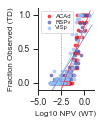

In [102]:
fig, ax = plt.subplots(figsize = (1, 1.5))
sns.regplot('log_npv', 'pobs', data = acad, fit_reg = False, color = 'r',
           scatter_kws={'s': 10,
                        'linewidth':0.5,
                       'alpha': 0.7}, label = 'ACAd')
sns.regplot('log_npv', 'pobs', data = acad, 
            scatter = False, ci = False, color = 'r', line_kws={'linewidth': 0.5})

sns.regplot('log_npv', 'pobs', data = rspv, fit_reg = False, color = '#5252a9',
           scatter_kws={'s': 10,
                        'linewidth':0.5,
                       'alpha': 0.7}, label = 'RSPv')
sns.regplot('log_npv', 'pobs', data = rspv, 
            scatter = False, ci = False, color = '#525289', line_kws={'linewidth': 0.5})

sns.regplot('log_npv', 'pobs', data = visp, fit_reg = False, color = '#90bff9',
           scatter_kws={'s': 10,
                        'linewidth':0.5,
                       'alpha': 0.7}, label = 'VISp')
sns.regplot('log_npv', 'pobs', data = visp, 
            scatter = False, ci = False, color = '#90bff9', line_kws={'linewidth': 0.5})
sns.despine()
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-5, 1])
ax.set_xticks([-5, -2.5, 0])
ax.tick_params(bottom=True, left=True)
ax.set_xlabel('Log10 NPV (WT)', fontsize = 8)
ax.set_ylabel('Fraction Observed (TD)', fontsize = 8)
plt.axvline(x=-2.5, color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend(loc = 2, fontsize = 6, labelspacing = 0.1, handletextpad = 0)
plt.savefig(os.path.join(savepath, 'NPV_fraction_observed_RSPv_ACAd_VISp.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [103]:
sources = []
npvs = []
fr_det = []
valid_str_ids = [ia_map[structure] for structure in valid_strs]
for source in alldat['source'].unique():
    isids = alldat[alldat['source'] == source]['image_series_id'].unique()
    if len(isids) > 1:
        new_expts = [868641659, 900250452]
        isids = [isid for isid in isids if isid not in new_expts]
        match_isids = alldat[alldat['source'] == source]['match_id'].unique()
        unionize_dat = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = isids,
                                                    is_injection = False,
                                                    hemisphere_ids = [1,2],
                                                    structure_ids = valid_str_ids))
        wt_unionize = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = match_isids,
                                                    is_injection = False,
                                                    hemisphere_ids = [1,2],
                                                    structure_ids = valid_str_ids))
        for isid in match_isids:
            inj_hem = aapi.get_hemisphere(isid)
            if inj_hem == 2:
                wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                                (wt_unionize['hemisphere_id'] == 2), 'hemisphere_id'] = 0
                wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                                (wt_unionize['hemisphere_id'] == 1), 'hemisphere_id'] = 2
                wt_unionize.loc[(wt_unionize['experiment_id'] == isid) &
                                (wt_unionize['hemisphere_id'] == 0), 'hemisphere_id'] = 1
        mean_npv = wt_unionize.groupby(['structure_id',
                                        'hemisphere_id'])['normalized_projection_volume'].mean()
        unionize_dat['thresholded_npv'] = unionize_dat['normalized_projection_volume']
        unionize_dat.loc[np.log10(unionize_dat['normalized_projection_volume']+0.0001) < -1.5, 
                         'thresholded_npv'] = 0

        det = unionize_dat[unionize_dat['thresholded_npv'] != 0].groupby(
            ['structure_id', 'hemisphere_id']).count().reset_index()[[
            'structure_id', 'hemisphere_id', 'thresholded_npv']]
        det = unionize_dat.groupby(['structure_id', 'hemisphere_id']).count().reset_index()[[
            'structure_id', 'hemisphere_id', 'normalized_projection_volume']].merge(
            det, on = ['structure_id', 'hemisphere_id'], how = 'left')
        det.loc[det['thresholded_npv'].isnull(), 'thresholded_npv'] = 0 # this will be count
        det['pobs'] = det['thresholded_npv']/det['normalized_projection_volume']
        det = det[['structure_id', 'hemisphere_id', 'pobs']]
        det = det.merge(mean_npv, on=['structure_id', 'hemisphere_id'])
        det['log_npv'] = np.log10(det['normalized_projection_volume']+0.0001)
        npvs.append(det['log_npv'])
        fr_det.append(det['pobs'])
        sources.append(source)

In [104]:
sources

['VISp',
 'VISl',
 'ORBvl',
 'ACAd',
 'MOs',
 'ACAv',
 'ORBl',
 'RSPv',
 'VISpor',
 'RSPagl',
 'VISam',
 'ORBm',
 'RSPd',
 'VISpm',
 'PL',
 'ECT']

In [105]:
df = pd.DataFrame(columns = ['source', 'log_NPV', 'fraction_det'])
for ix, source in enumerate(sources):
    newdf = pd.DataFrame(columns = ['source', 'log_NPV', 'fraction_det'])
    newdf['log_NPV'] = npvs[ix]
    newdf['fraction_det'] = fr_det[ix]
    newdf['source'] = source
    df = pd.concat([df, newdf])

In [106]:
formula = 'fraction_det~log_NPV*C(source)' 
model = ols(formula, df).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(source),8.6226,15.0,11.7789,0.0
log_NPV,128.8616,1.0,2640.4803,0.0
log_NPV:C(source),7.3186,15.0,9.9977,0.0
Residual,65.5903,1344.0,NaN,NaN


In [107]:
corrs = []
pvals = []
for ix in np.arange(len(npvs)):
    x = npvs[ix]
    y = fr_det[ix]
    corrs.append(scipy.stats.spearmanr(x, y)[0])
    pvals.append(scipy.stats.spearmanr(x, y)[1])

In [108]:
fdrcorr = sm.stats.fdrcorrection(pvals, alpha=0.05, method='indep')
for ix in np.arange(len(npvs)):
    print(alldat['source'].unique()[ix])
    print(corrs[ix])
    print(fdrcorr[0][ix])

VISp
0.825871372900852
True
VISl
0.896313584745748
True
ORBvl
0.8907474541184908
True
ACAd
0.8999096621513775
True
MOs
0.8446839019397201
True
ACAv
0.7247649692469548
True
ORBl
0.7354699362989645
True
RSPv
0.8939093836223111
True
VISpor
0.8221707934109475
True
RSPagl
0.891925220057002
True
VISam
0.8957869145578533
True
VISa
0.8510384157508695
True
VISrl
0.7656055924858219
True
ORBm
0.8699409356579778
True
RSPd
0.7609534652695419
True
VISpm
0.6514421292837475
True


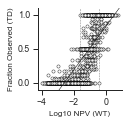

In [109]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.regplot('log_NPV', 'fraction_det', fit_reg = True, ci=False, data = df, color = 'w',
           scatter_kws={'s': 10,
                        'edgecolor': 'k',
                        'linewidth':0.5},
           line_kws={'color': 'k',
                    'linewidth':0.5})
sns.despine()
ax.set_ylim([-0.1, 1.1])
#ax.set_xlim([-3, 1])
ax.tick_params(bottom=True, left=True)
ax.set_xlabel('Log10 NPV (WT)', fontsize = 8)
ax.set_ylabel('Fraction Observed (TD)', fontsize = 8)
plt.axvline(x=df[df['fraction_det'] == 0]['log_NPV'].max(),
            color = 'gray', linestyle = '--', linewidth = 0.5, zorder = -1)
plt.axvline(x=df[df['fraction_det'] == 1]['log_NPV'].min(),
           color = 'gray', linestyle = '--', linewidth = 0.5, zorder = -1)
plt.savefig(os.path.join(savepath, 'NPV_fraction_observed.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [110]:
print(10**(df[df['fraction_det'] == 1]['log_NPV'].min()))
print(10**(df[df['fraction_det'] == 1]['log_NPV'].max()))

0.0229388783949394
5.471033559239708


In [111]:
print(10**(df[df['fraction_det'] == 0]['log_NPV'].min()))
print(10**(df[df['fraction_det'] == 0]['log_NPV'].max()))

0.00010572631075430462
0.3750948963564172


In [112]:
print(10**(df[df['fraction_det'] == 0]['log_NPV'].max()) - 10**(df[df['fraction_det'] == 1]['log_NPV'].min()))

0.3521560179614778


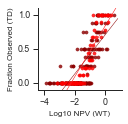

In [113]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.regplot('log_NPV', 'fraction_det', 
            fit_reg = True, ci=False, data = df[df['source'].isin(['ORBl', 'ORBvl'])], 
            color = 'darkred',
           scatter_kws={'s': 10,
                        'linewidth':0.5},
           line_kws={'linewidth':0.5})
sns.regplot('log_NPV', 'fraction_det', 
            fit_reg = True, ci=False, data = df[df['source'] == 'ACAd'], color = 'r',
           scatter_kws={'s': 10,
                        'linewidth':0.5},
           line_kws={'linewidth':0.5})
sns.despine()
ax.set_ylim([-0.1, 1.1])
#ax.set_xlim([-3, 1])
ax.tick_params(bottom=True, left=True)
ax.set_xlabel('Log10 NPV (WT)', fontsize = 8)
ax.set_ylabel('Fraction Observed (TD)', fontsize = 8)
plt.savefig(os.path.join(savepath, 'NPV_fraction_observed_ACAd_ORBlvl.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [114]:
scipy.stats.pearsonr(df['log_NPV'], df['fraction_det'])

(0.7911209833131474, 1.2560155320517777e-295)

In [115]:
formula = 'fraction_det~log_NPV*C(source)' 
model = ols(formula, df).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(source),8.6226,15.0,11.7789,0.0
log_NPV,128.8616,1.0,2640.4803,0.0
log_NPV:C(source),7.3186,15.0,9.9977,0.0
Residual,65.5903,1344.0,NaN,NaN
